In [113]:
# Problema 1: Formato do arquivo (separação das palavras)
# Problema 2: Quantidade de colunas variável

import pandas as pd
import numpy as np

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [100]:
input = pd.DataFrame([line.strip().split(';') for line in open('AntBNC_lemmas_ver_002.txt', 'r')])

In [101]:
input.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,h,aaahed,aaah,None,None,None,None,None,None,None,None,None,None
1,aac,aac,aacs,None,None,None,None,None,None,None,None,None,None
2,aah,aah,aahs,aahing,aahed,aahhing,None,None,None,None,None,None,None
3,aam,aams,aam,None,None,None,None,None,None,None,None,None,None
4,aardvark,aardvark,aardvarks,None,None,None,None,None,None,None,None,None,None


In [102]:
x = []
y = []
for row in input.values:
    linha = [''.join(row[:1]), [x for x in row[1:] if x is not None]]
    x.append(len(linha[0]))
    y.append(len(linha[1]))
    #print("Tamanho: "+str(len(linha[0])) + " / Qtd Lemas: " + str(len(linha[1])))

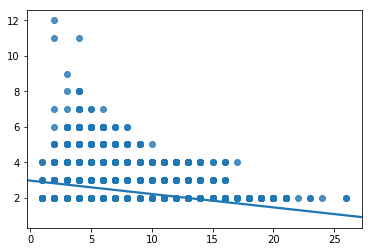

In [103]:
sb.regplot(x=np.array(x), y=np.array(y))

Text(0,0.5,'Quantidade de lemas relacionados')

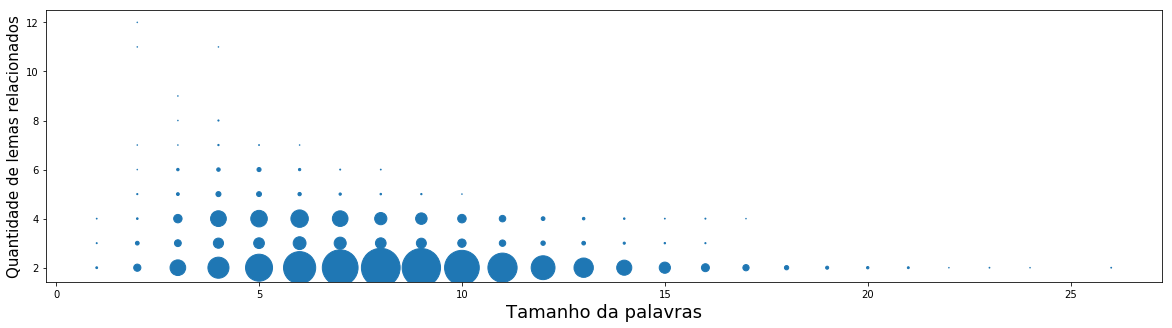

In [105]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['c'] = 1
df = df.groupby(['x', 'y'])['c'].sum().reset_index()

fig = plt.figure(figsize=(20,5))
plt.scatter(df['x'], df['y'], s=df['c']/3)
plt.xlabel("Tamanho da palavras", fontsize=18)
plt.ylabel("Quantidade de lemas relacionados", fontsize=15)

In [124]:
print(df[['x', 'y']].corr())

          x         y
x  1.000000 -0.495313
y -0.495313  1.000000


In [106]:
x1 = np.asarray(x)
x1 = x1.reshape(-1, 1)

y1 = np.asarray(y)
y1 = y1.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x1,y1, test_size=0.2, random_state=1)

In [107]:
log = linear_model.LogisticRegression()

In [108]:
log.fit(x_train, y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [109]:
y_pred = log.predict(x_test)

In [110]:
print("Score Regressão Logística: " + str(log.score(x_test, y_test)))

Score Regressão Logística: 0.788970683198
